# Audio Spectrum Display Simulation
Using this notebook you can generate sinewayes samples and use them in embedded system for testing. Samples are then transformed using FFT and then visualise. You can also evaluate spectrum bins based FFT samples and output bands count.

For further informations check out [Github](https://github.com/Gieneq/Audio-Spectrum-Display)

## Assumptions

* Sampling frequency: 44 kHz,
* Max frequency (Nyquist theorem): 22 kHz,
* Numbber of FFT bins: 1024,
* Number of bands: 19,
* Bins to bands assignment function: exponential.

The goal is to achieve FFT refreshrate of not less then 30 Hz. [STM32F3](https://www.st.com/en/microcontrollers-microprocessors/stm32f303.html#overview) series will be used to sample signal with builtin 12 bit ultra-fast SAR ADC.



# Input signal



Sampling time: 46.55 ms of 2048 samples with 44000.0 sps


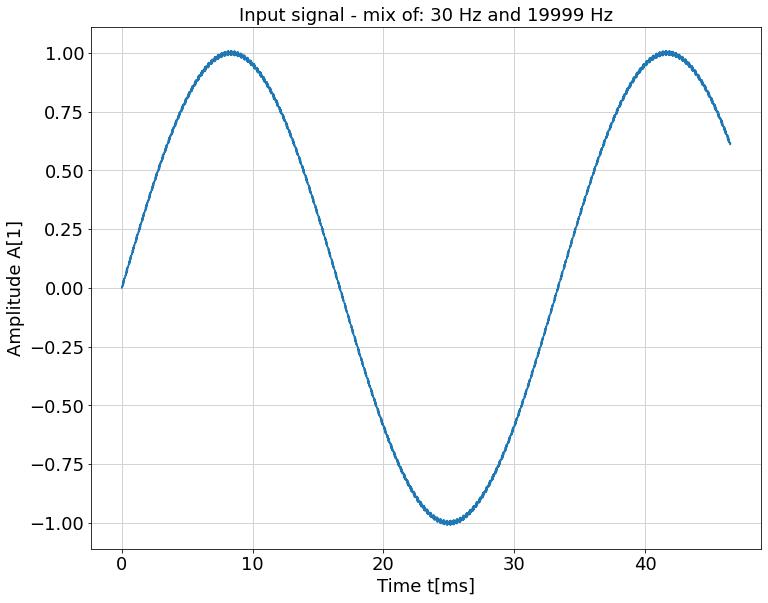

In [162]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import pi
plots_scale = 0.8
plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

# Twice as many samples are needed
samples_count = 2*1024
sampling_frequency = 44e3

# Testing frequencies
frequency_1 = 30
frequency_2 = 19999

sampling_time = samples_count * 1/sampling_frequency
print(f"Sampling time: {round(sampling_time*1000, 2)} ms of {samples_count} samples with {sampling_frequency} sps")

t = np.arange(samples_count)/sampling_frequency
val = np.sin(2*pi*frequency_1*t) + 0.01 * np.sin(2*pi*frequency_2*t)

plt.plot(t*1000, val)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title(f"Input signal - mix of: {frequency_1} Hz and {frequency_2} Hz", fontsize=18)
plt.show()


# FFT Evaluation
Fast Fourier Transformation lets transform time-base samples of the signal to frequency-based magnitudes. The magnitude depict the content of specific frequency in the signal.

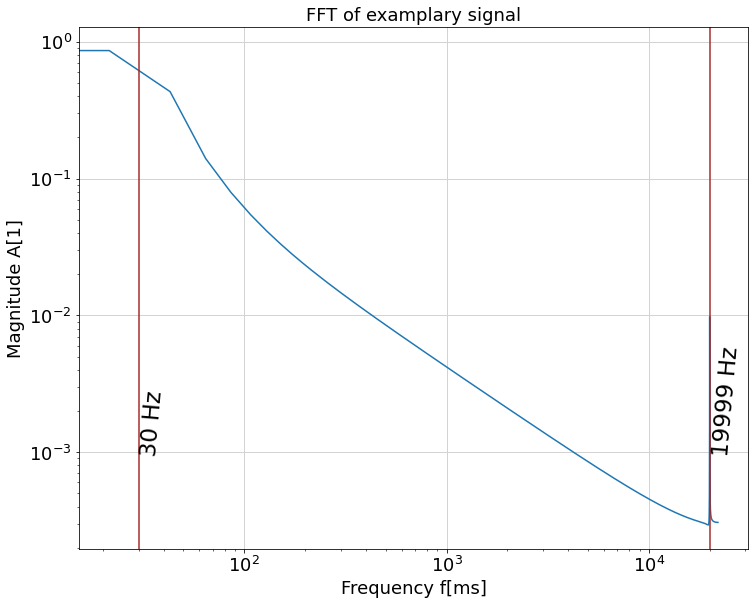

In [163]:
import scipy.fftpack


yf = scipy.fftpack.fft(val)
xf = sampling_frequency*np.arange(samples_count)/samples_count

freqs = xf[:samples_count//2]
mags = 2.0/samples_count * np.abs(yf[:samples_count//2])

sig_fft_real = yf.real
sig_fft_imag = yf.imag

plt.plot(freqs, mags)
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

# Bins and bands

In some cases all resulting FFT magnitude samples are not needed. They can be condensated using bands. Each bands represents specific frequency range in which corresponding frequency magnitudes are added.

To help evalueating this process **bins LUT** (Lookup table) is made.

Worth mentioning is that it is better to use exponential function to calculate bins indices. You can compare it to looking at FFT with or without logscale. Low frequencies are visualised more precisely than higher ones. Using linear function all bands will hase the same band widths.


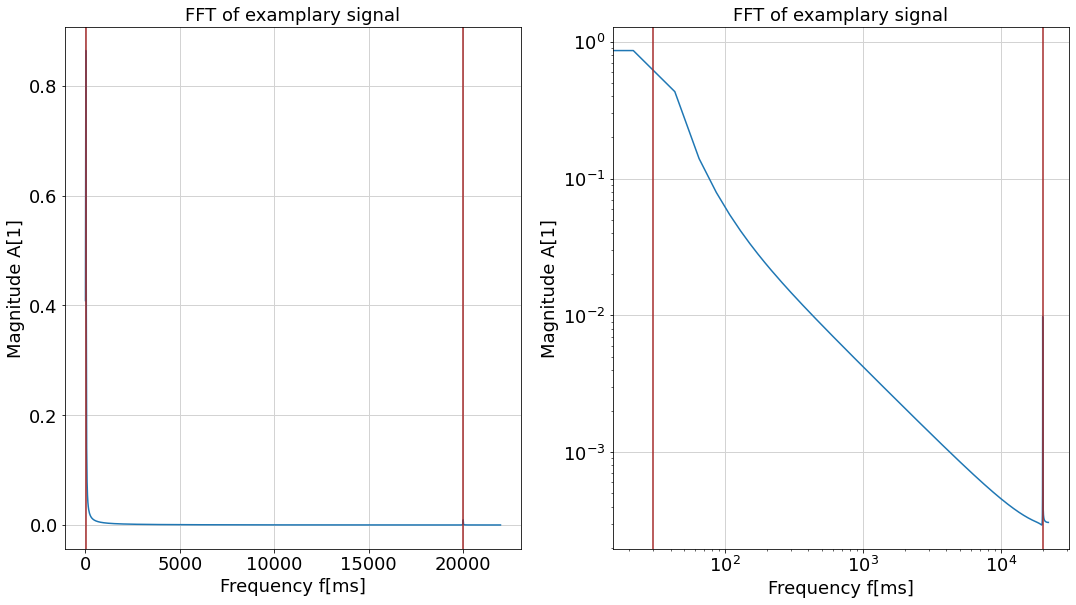

In [164]:
plt.rcParams['figure.figsize'] = [plots_scale*15*1.5, plots_scale*12]

plt.subplot(1, 2, 1)
plt.plot(freqs, mags)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Lin scale', fontsize=18)

plt.subplot(1, 2, 2)
plt.xscale("log")
plt.yscale("log")
plt.plot(freqs, mags)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Log scale', fontsize=18)

plt.show()

plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

# Bins function

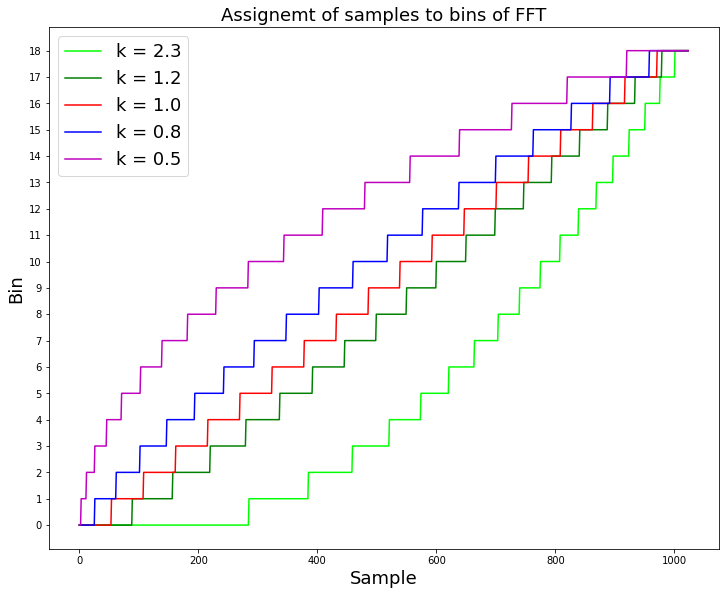

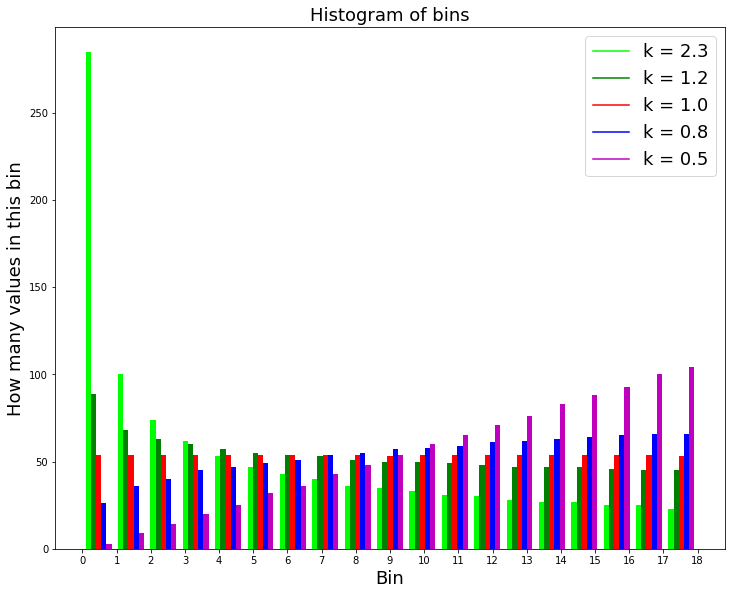

In [165]:
from collections import Counter
from math import floor

bands_count = 19

def gen_bins(bands_count, samples_count, k=1.0):
  return [floor(bands_count*(i/samples_count)**k) for i in range(0, samples_count)]


samples_idx = [i for i in range(0, samples_count // 2)]

k_factors = [2.3, 1.2, 1.0, 0.8, round(1/2, 2)]
plot_colors = ['lime', 'g', 'r', 'b', 'm']
plot_labels = [f"k = {k}" for k in k_factors]
bins_per_k = [gen_bins(bands_count, samples_count // 2, k) for k in k_factors]

lines = [plt.plot(samples_idx, [str(bin) for bin in bins], plot_colors[idx])[0] for idx, bins in enumerate(bins_per_k)]
plt.title('Assignemt of samples to bins of FFT', fontsize=18)
plt.ylabel('Bin', fontsize=18)
plt.xlabel('Sample', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.show()

plt.hist([[str(bin) for bin in bins] for bins in bins_per_k], density=False, bins=bands_count, color=plot_colors, label=plot_labels)  # density=False would make counts
plt.title('Histogram of bins', fontsize=18)
plt.ylabel('How many values in this bin', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.show()


# Band width

Elements per bin:  {0: 2, 1: 5, 2: 10, 3: 16, 4: 20, 5: 27, 6: 32, 7: 38, 8: 45, 9: 51, 10: 58, 11: 65, 12: 72, 13: 79, 14: 86, 15: 93, 16: 101, 17: 109, 18: 115} , total:  1024 

Bin 0 from 0.0 Hz to 43.01 Hz, range: 43.01 Hz
Bin 1 from 43.01 Hz to 150.54 Hz, range: 107.53 Hz
Bin 2 from 150.54 Hz to 365.59 Hz, range: 215.05 Hz
Bin 3 from 365.59 Hz to 709.68 Hz, range: 344.09 Hz
Bin 4 from 709.68 Hz to 1139.78 Hz, range: 430.11 Hz
Bin 5 from 1139.78 Hz to 1720.43 Hz, range: 580.65 Hz
Bin 6 from 1720.43 Hz to 2408.6 Hz, range: 688.17 Hz
Bin 7 from 2408.6 Hz to 3225.81 Hz, range: 817.2 Hz
Bin 8 from 3225.81 Hz to 4193.55 Hz, range: 967.74 Hz
Bin 9 from 4193.55 Hz to 5290.32 Hz, range: 1096.77 Hz
Bin 10 from 5290.32 Hz to 6537.63 Hz, range: 1247.31 Hz
Bin 11 from 6537.63 Hz to 7935.48 Hz, range: 1397.85 Hz
Bin 12 from 7935.48 Hz to 9483.87 Hz, range: 1548.39 Hz
Bin 13 from 9483.87 Hz to 11182.8 Hz, range: 1698.92 Hz
Bin 14 from 11182.8 Hz to 13032.26 Hz, range: 1849.46 Hz
Bin 15 from 1303

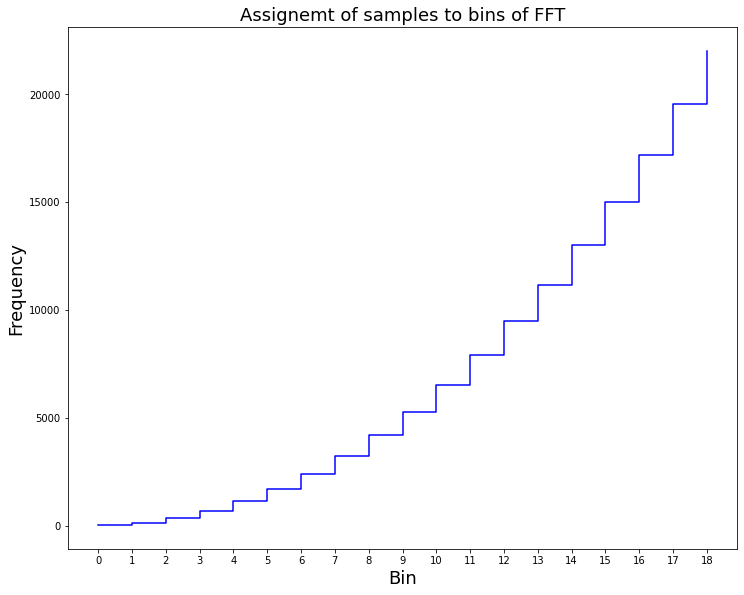

In [166]:
bins_assignment_k = 0.45
bins = gen_bins(bands_count, samples_count // 2, bins_assignment_k)

resolution_width = sampling_frequency/2 / (samples_count // 2-1)
# print(f"Single resoolution width: {round(bin_width, 3)} Hz\n")

bins_count = dict(Counter(bins))
print("Elements per bin: ", bins_count, ", total: ", sum(bins_count.values()) , "\n")

ranges = [0]*bands_count

for idx in range(bands_count):
  band_width = bins_count[idx] * resolution_width
  ranges[idx] = ranges[idx - 1] + band_width if idx > 0 else band_width
  print(f"Bin {idx} from {round(ranges[idx] - band_width, 2)} Hz to {round(ranges[idx],2)} Hz, range: {round(band_width, 2)} Hz")

# plt.plot([str(bin) for bin in bins], samples_idx, 'r')
plt.step([str(bin) for bin in set(bins)], ranges, 'b', where='post')
plt.title('Assignemt of samples to bins of FFT', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()




# Audio Spectrum Display Visualization

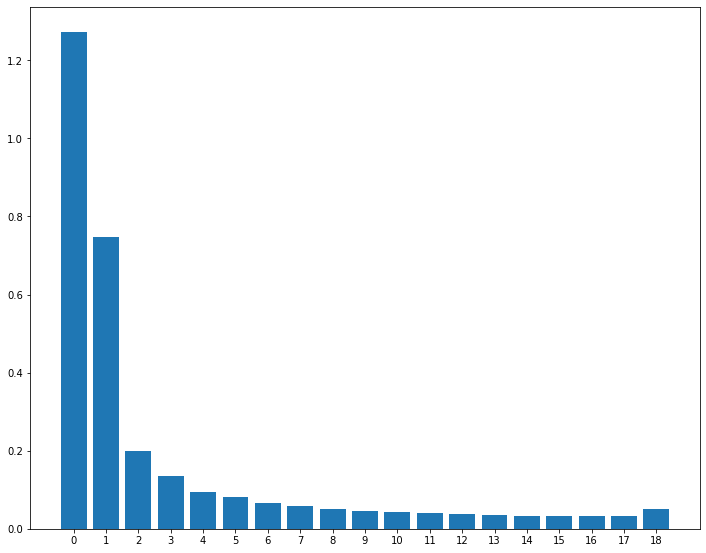

In [167]:
columns_values = [0]*bands_count

for idx, mag in enumerate(mags):
  columns_values[bins[idx]] += mag

plt.bar([str(i) for i in range(bands_count)], columns_values)
plt.show()



## Output bins

In [168]:
variable_name_bins_count = "BINS_COUNT"
print(f"#define {variable_name_bins_count} {len(bins)}")
print(f"const int bins[{variable_name_bins_count}] = " + "{" + str(bins)[1:-1] + "};")

#define BINS_COUNT 1024
const int bins[BINS_COUNT] = {0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

# Signal Samples

Time-based

In [169]:
variable_name_test_samples_count = "TEST_SAMPLES_COUNT"
print(f"#define {variable_name_test_samples_count} {len(val)}")
print(f"const int bins[{variable_name_test_samples_count}] = " + "{" + str(val)[1:-1] + "};")

#define TEST_SAMPLES_COUNT 2048
const int bins[TEST_SAMPLES_COUNT] = {0.         0.00710267 0.00315906 ... 0.61635069 0.61002676 0.61497917};


# IFFT check

To recreate time-based signal both imaginary and real parts of output FFT are needed. Samples count is equal starting samples count (twice as many).

Time samples count: (2048,)
FFT output samples, real part count: (2048,)
FFT output samples, imaginary part count: (2048,)
To check rersults fill the arrays (of length 2048) from output of embedded system.


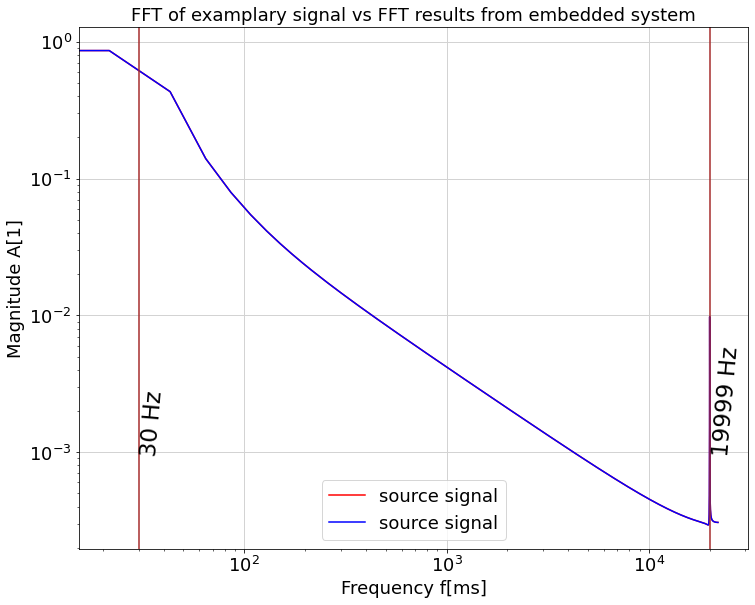

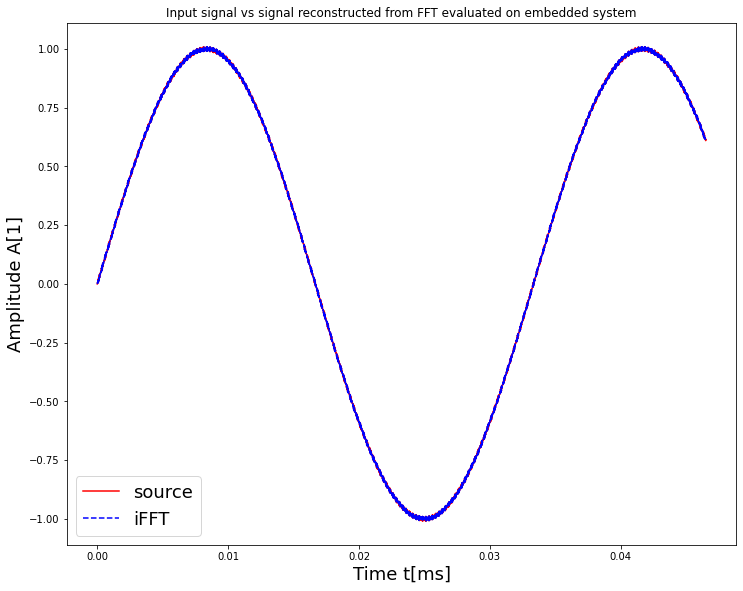

In [170]:
print(f"Time samples count: {t.shape}")
xf = sampling_frequency*np.arange(samples_count//2)/samples_count

print(f"FFT output samples, real part count: {sig_fft_real.shape}")
print(f"FFT output samples, imaginary part count: {sig_fft_imag.shape}")
sig_fft = sig_fft_real + 1j*sig_fft_imag
source_mags = 2.0/samples_count * np.abs(sig_fft_real + 1j*sig_fft_imag)[:samples_count//2]

print(f"To check rersults fill the arrays (of length {len(t)}) from output of embedded system.")
# Fill those arrays with readings, full length equal 'samples_count'
res_fft_real = np.copy(sig_fft_real)
res_fft_imag = np.copy(sig_fft_imag)
resulting_mags = 2.0/samples_count * np.abs(res_fft_real + 1j*res_fft_imag)[:samples_count//2]

plt.xscale("log")
plt.yscale("log")
plt.plot(xf, source_mags, 'r', label='source signal')
plt.plot(xf, resulting_mags, 'b', label='source signal')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal vs FFT results from embedded system', fontsize=18)
plt.legend(fontsize=18)
plt.show()


s = np.fft.ifft(res_fft_real + 1j*res_fft_imag)
plt.plot(t, val, label='source', color='r')
plt.plot(t, s.real, '--', label='iFFT', color='b')
plt.legend(fontsize=18)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT evaluated on embedded system")
plt.show()

## References

How to use STM32 CMSIS FFT library in STM32CubeIDE's project: 
https://community.st.com/s/article/configuring-dsp-libraries-on-stm32cubeide

STM32F303VCT Mouser https://www.mouser.pl/ProductDetail/STMicroelectronics/STM32F303VCT6?qs=MgMGkPeFqc9kq0wunoFB9Q%3D%3D
